In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import  train_test_split
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor
import pickle
import gzip

os.chdir('../')
from functions.model_wrapper import Tree_Model, rfm_params, xgboost_params, get_y_w_threshold
from functions.dataprep import group_values, replace_DateTime_CycleTime, strong_low_pass_filter

# These are batteries that show anomalies in the measnurements, and are therefore excluded.
excl_filenames = ['2018-04-12_batch8_CH46', '2017-06-30_3_6C-30per_6C_CH15', '2017-06-30_2C-7per_5_5C_CH12',
                  '2018-04-12_batch8_CH46', '2017-06-30_6C-60per_3C_CH48']

In [2]:
with gzip.open('data/filtered_data_frames.pckl', 'rb') as f:
    filtered_data_frames = pickle.load(f)

In [3]:
# get y which is number of cycle it dropped below threshold
threshold = 0.9
X_CC =  filtered_data_frames[0]
X_CC = X_CC[[col for col in X_CC.columns if col not in excl_filenames]]

y_all = get_y_w_threshold(X_CC, threshold)

In [4]:
filtered_data_frames[1].iloc[:1000,:]
y_all.isnull().sum()

np.int64(0)

In [5]:
first100rows_data_frames = [data_frame.iloc[: 100, :] for data_frame in filtered_data_frames]
X_all = pd.concat(first100rows_data_frames, axis = 0).T
X_all = X_all.T[[col for col in X_all.T.columns if col not in excl_filenames]].T
X_all.iloc[:,:]

,2_Charge_Capacity,3_Charge_Capacity,4_Charge_Capacity,5_Charge_Capacity,6_Charge_Capacity,7_Charge_Capacity,8_Charge_Capacity,9_Charge_Capacity,10_Charge_Capacity,11_Charge_Capacity,...,95_CycleTime,96_CycleTime,97_CycleTime,98_CycleTime,99_CycleTime,100_CycleTime,101_CycleTime,102_CycleTime,103_CycleTime,schedule_version
2017-06-30_4_4C-55per_6C_CH19,1.0,0.999469,1.00071,1.001153,1.000947,1.001061,1.001048,1.000631,1.000738,1.000275,...,60.08787,60.09993,60.073277,60.201067,60.051363,59.927752,59.978472,60.083027,60.102322,7.00.08
2018-04-12_batch8_CH38,1.0,1.000355,1.000647,1.000878,1.000875,1.000858,1.000857,1.000757,1.000705,1.000661,...,44.572147,44.595965,44.517665,44.467317,44.607613,44.443833,44.560172,44.453385,44.395298,7.00.13
2018-04-12_batch8_CH10,1.0,1.000607,1.001124,1.001623,1.001856,1.002276,1.002395,1.002756,1.002865,1.002884,...,45.419542,45.475585,45.395157,45.50357,45.584997,45.602177,45.54824,45.590342,45.659787,7.00.13
2017-05-12_7C-30per_3_6C_CH39,1.0,1.000993,1.001488,1.001663,1.001903,1.002134,1.002336,1.001566,1.002752,1.00285,...,51.484705,51.59691,51.481427,51.508457,51.560358,51.482802,51.47205,51.505393,51.495503,7.00.08
2017-06-30_3_6C-80per_3_6C_CH1,1.0,0.999561,1.000024,1.000403,1.000303,0.999825,1.000283,1.000705,0.999735,0.999578,...,50.087073,50.087073,50.087073,49.815145,49.894612,49.894612,49.504907,49.383853,49.366305,7.00.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-12_7C-40per_3_6C_CH41,1.0,1.001021,1.001249,1.001563,1.001953,1.002248,1.002405,1.002483,1.002725,1.00276,...,51.14329,51.143787,51.142278,51.142218,51.158852,51.14201,51.14202,51.141435,51.13668,7.00.08
2018-04-12_batch8_CH21,1.0,1.000793,1.001366,1.001734,1.002036,1.002051,1.002263,1.002459,1.002619,1.002509,...,47.25177,47.300742,47.320268,47.225552,47.243885,47.211918,47.227287,47.310093,47.234753,7.00.13
2018-04-12_batch8_CH35,1.0,1.000817,1.001465,1.001803,1.00217,1.002625,1.002845,1.003059,1.003236,1.003206,...,46.481423,46.433762,46.388213,46.468112,46.503998,46.24005,46.298525,46.364928,46.464727,7.00.13
2017-06-30_4_8C-80per_4_8C_CH8,1.0,1.002038,1.003053,1.003054,1.003826,1.004159,1.003788,1.004376,1.004534,1.004396,...,59.879507,59.86149,59.810603,59.786073,59.821895,59.822375,59.826117,59.869312,59.802775,7.00.08


In [6]:
X_all.fillna(0, inplace = True)

In [7]:
with gzip.open('data/CC_data_frames_FFT.pckl', 'rb') as f:
    CC_data_frames_FFT = pickle.load(f)
df_FF_peaks = pd.concat(CC_data_frames_FFT)
X_all = pd.merge(X_all, df_FF_peaks, left_index=True, right_index=True)

In [8]:
with gzip.open('data/CV_data_frames_FFT.pckl', 'rb') as f:
    CV_data_frames_FFT = pickle.load(f)
df_FF_peaks = pd.concat(CV_data_frames_FFT)

X_all = pd.merge(X_all, df_FF_peaks, left_index=True, right_index=True)

In [9]:
X_all["schedule_version"] = X_all["schedule_version"] == '7.00.08'

In [10]:
X_all = X_all.astype('float')
X_all['schedule_version'] = X_all['schedule_version'].astype('bool')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    train_size=0.8, test_size=0.2, 
                                                    random_state=120)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    train_size=0.9, test_size=0.1, 
                                                    random_state=
                                                  120)
xgboost_params['eval_set'] = [(X_train, y_train), (X_val, y_val)]

In [12]:
xgboost_params["n_jobs"] = 7
xgboost_params['n_estimators'] = 100_000_000
xgboost_params['learning_rate'] = 1e-5

xgboost_params["verbose"] = 1000
xgboost_params["early_stopping_rounds"] = 1000

[01:03:54] ======== Monitor (0): HostSketchContainer ========
[01:03:54] AllReduce: 0.000212s, 1 calls @ 212us

[01:03:54] MakeCuts: 0.000363s, 1 calls @ 363us

[01:03:54] DEBUG: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:331.70763	validation_1-rmse:218.51898


/Users/willtong/Library/Caches/pypoetry/virtualenvs/wine-libraries-x_qLj7z9-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:03:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	validation_0-rmse:330.06176	validation_1-rmse:216.69740
[2000]	validation_0-rmse:328.43659	validation_1-rmse:214.90220
[3000]	validation_0-rmse:326.82293	validation_1-rmse:213.11781
[4000]	validation_0-rmse:325.23712	validation_1-rmse:211.36642
[5000]	validation_0-rmse:323.65712	validation_1-rmse:209.62491
[6000]	validation_0-rmse:322.11641	validation_1-rmse:207.92343
[7000]	validation_0-rmse:320.58127	validation_1-rmse:206.22794
[8000]	validation_0-rmse:319.06373	validation_1-rmse:204.54489
[9000]	validation_0-rmse:317.56678	validation_1-rmse:202.89406
[10000]	validation_0-rmse:316.08408	validation_1-rmse:201.25354
[11000]	validation_0-rmse:314.61777	validation_1-rmse:199.65686
[12000]	validation_0-rmse:313.16715	validation_1-rmse:198.06947
[13000]	validation_0-rmse:311.73754	validation_1-rmse:196.51760
[14000]	validation_0-rmse:310.31978	validation_1-rmse:194.96317
[15000]	validation_0-rmse:308.92987	validation_1-rmse:193.45824
[16000]	validation_0-rmse:307.55302	validation_1-

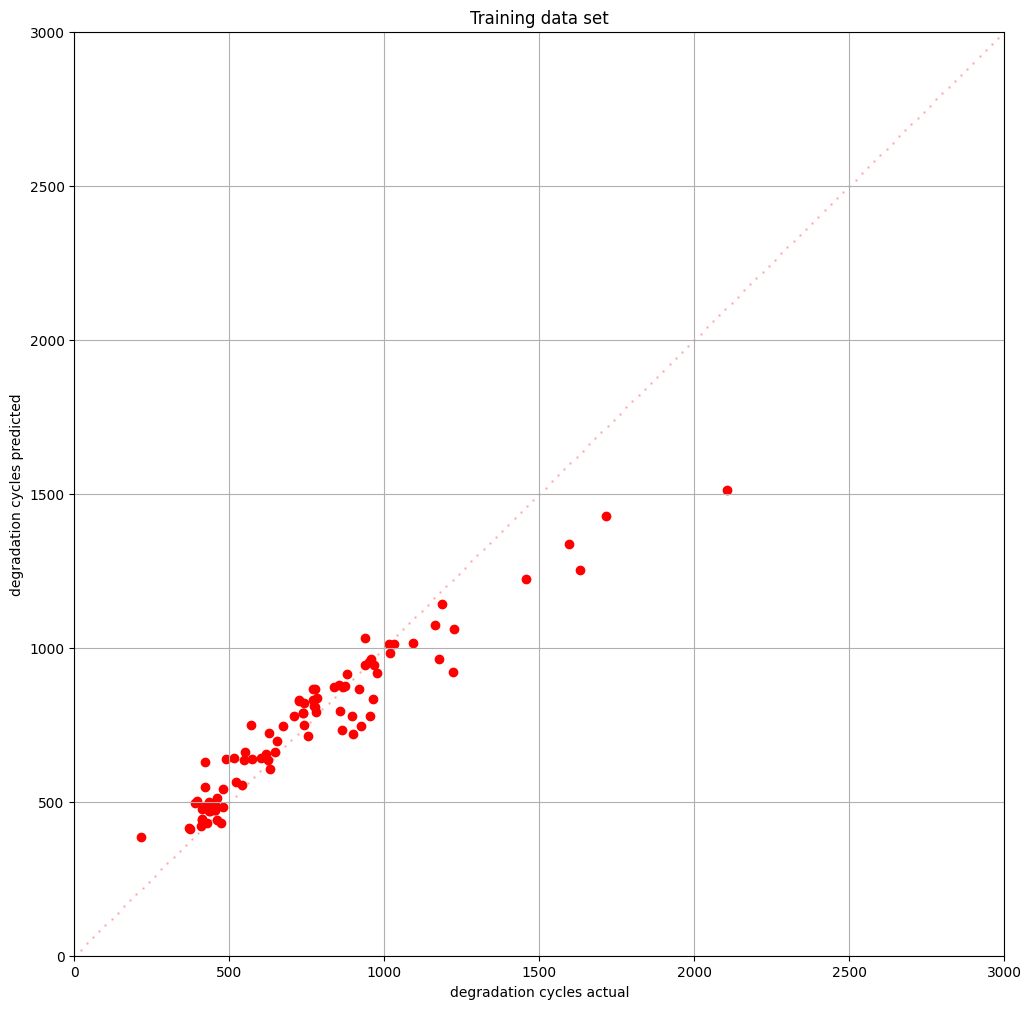

Max depth = 2
MdAPE is 15.33989920377028%
R2: 0.646, RMSE: 192.650, MAE: 147.022
Plotting scatter plot...


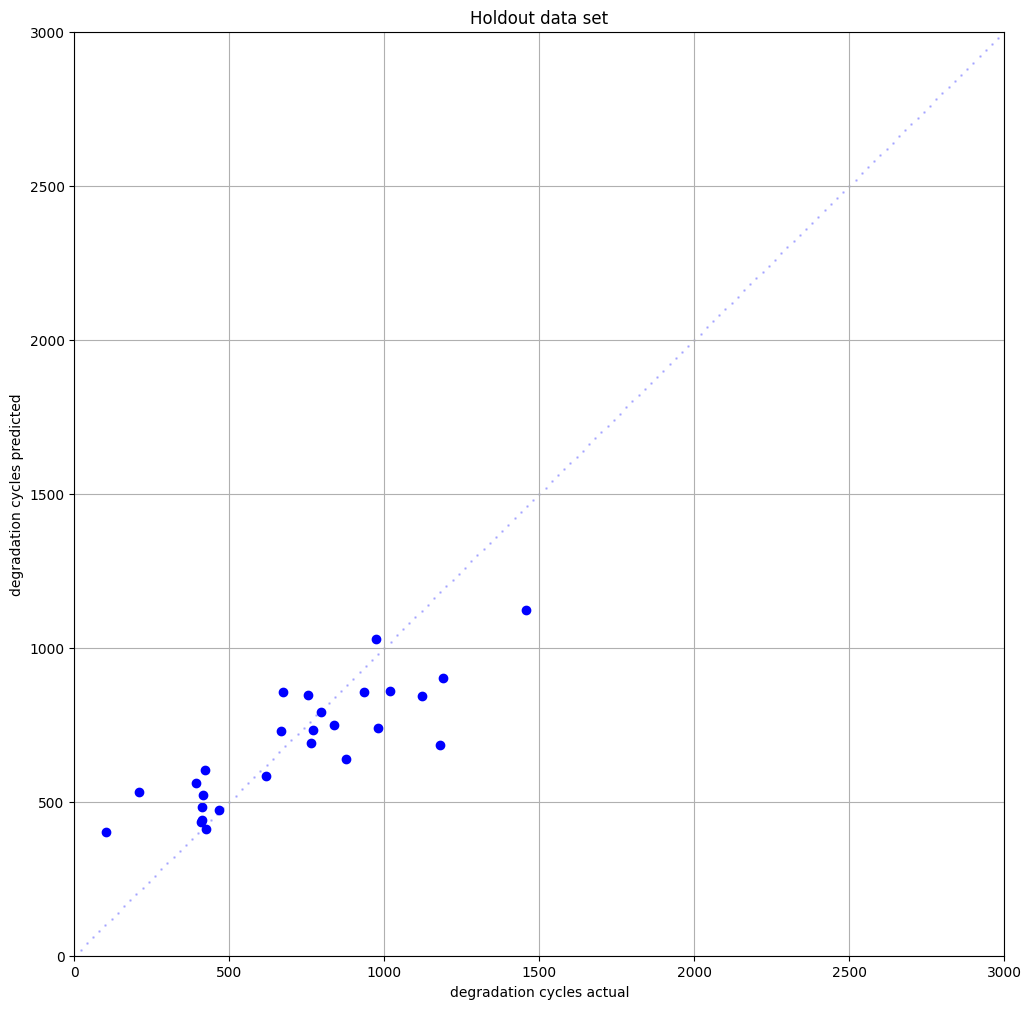

[01:13:47] ======== Monitor (0): HostSketchContainer ========
[01:13:47] AllReduce: 0.000194s, 1 calls @ 194us

[01:13:47] MakeCuts: 0.000336s, 1 calls @ 336us

[01:13:47] DEBUG: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:331.70698	validation_1-rmse:218.51911


/Users/willtong/Library/Caches/pypoetry/virtualenvs/wine-libraries-x_qLj7z9-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:13:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	validation_0-rmse:329.27342	validation_1-rmse:216.70527
[2000]	validation_0-rmse:326.86047	validation_1-rmse:214.90754
[3000]	validation_0-rmse:324.47109	validation_1-rmse:213.13324
[4000]	validation_0-rmse:322.10691	validation_1-rmse:211.38937
[5000]	validation_0-rmse:319.75652	validation_1-rmse:209.64339
[6000]	validation_0-rmse:317.43195	validation_1-rmse:207.94569
[7000]	validation_0-rmse:315.12184	validation_1-rmse:206.25659
[8000]	validation_0-rmse:312.84121	validation_1-rmse:204.59665
[9000]	validation_0-rmse:310.56924	validation_1-rmse:202.93259
[10000]	validation_0-rmse:308.31619	validation_1-rmse:201.29472
[11000]	validation_0-rmse:306.09076	validation_1-rmse:199.67415
[12000]	validation_0-rmse:303.87511	validation_1-rmse:198.06448
[13000]	validation_0-rmse:301.68602	validation_1-rmse:196.49105
[14000]	validation_0-rmse:299.51290	validation_1-rmse:194.93422
[15000]	validation_0-rmse:297.35891	validation_1-rmse:193.40248
[16000]	validation_0-rmse:295.22276	validation_1-

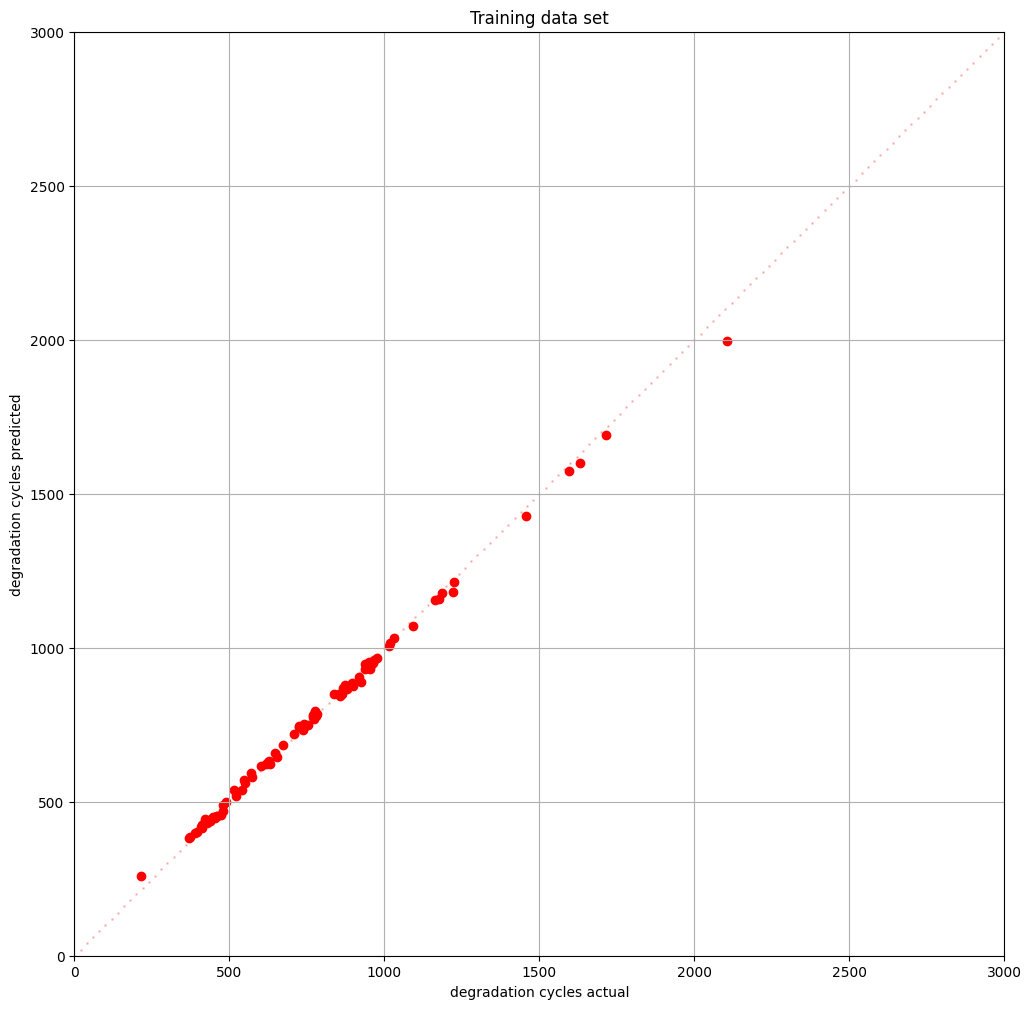

Max depth = 4
MdAPE is 12.857502775089111%
R2: 0.733, RMSE: 167.304, MAE: 129.617
Plotting scatter plot...


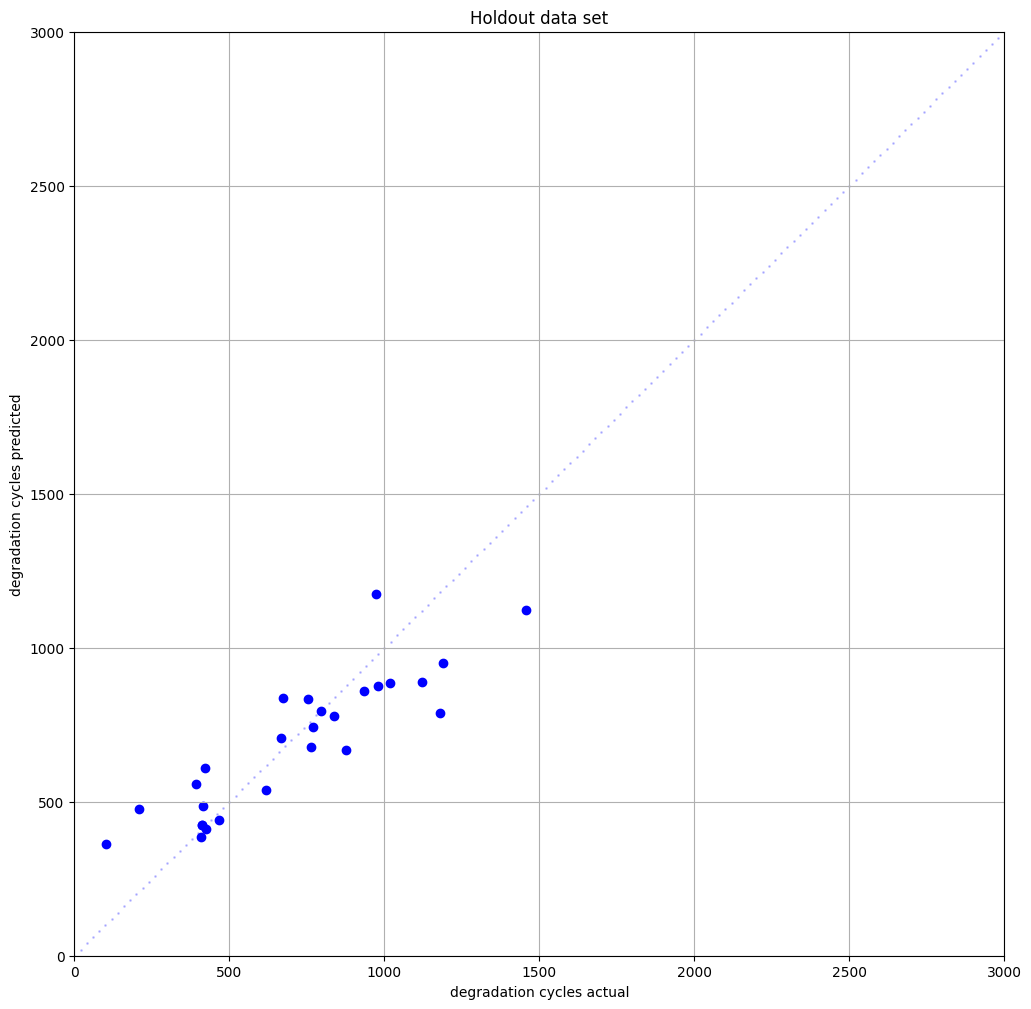

[01:37:05] ======== Monitor (0): HostSketchContainer ========
[01:37:05] AllReduce: 0.000205s, 1 calls @ 205us

[01:37:05] MakeCuts: 0.000372s, 1 calls @ 372us

[01:37:05] DEBUG: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:331.70675	validation_1-rmse:218.51909


/Users/willtong/Library/Caches/pypoetry/virtualenvs/wine-libraries-x_qLj7z9-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:37:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	validation_0-rmse:329.09452	validation_1-rmse:216.66278
[2000]	validation_0-rmse:326.51486	validation_1-rmse:214.86065
[3000]	validation_0-rmse:323.94852	validation_1-rmse:213.05348
[4000]	validation_0-rmse:321.40796	validation_1-rmse:211.27382
[5000]	validation_0-rmse:318.88535	validation_1-rmse:209.51787
[6000]	validation_0-rmse:316.39140	validation_1-rmse:207.78720
[7000]	validation_0-rmse:313.91152	validation_1-rmse:206.04888
[8000]	validation_0-rmse:311.45591	validation_1-rmse:204.33838
[9000]	validation_0-rmse:309.02591	validation_1-rmse:202.65674
[10000]	validation_0-rmse:306.61355	validation_1-rmse:200.99522
[11000]	validation_0-rmse:304.22056	validation_1-rmse:199.34860
[12000]	validation_0-rmse:301.84708	validation_1-rmse:197.71271
[13000]	validation_0-rmse:299.49911	validation_1-rmse:196.10603
[14000]	validation_0-rmse:297.16349	validation_1-rmse:194.49211
[15000]	validation_0-rmse:294.85781	validation_1-rmse:192.91768
[16000]	validation_0-rmse:292.56622	validation_1-

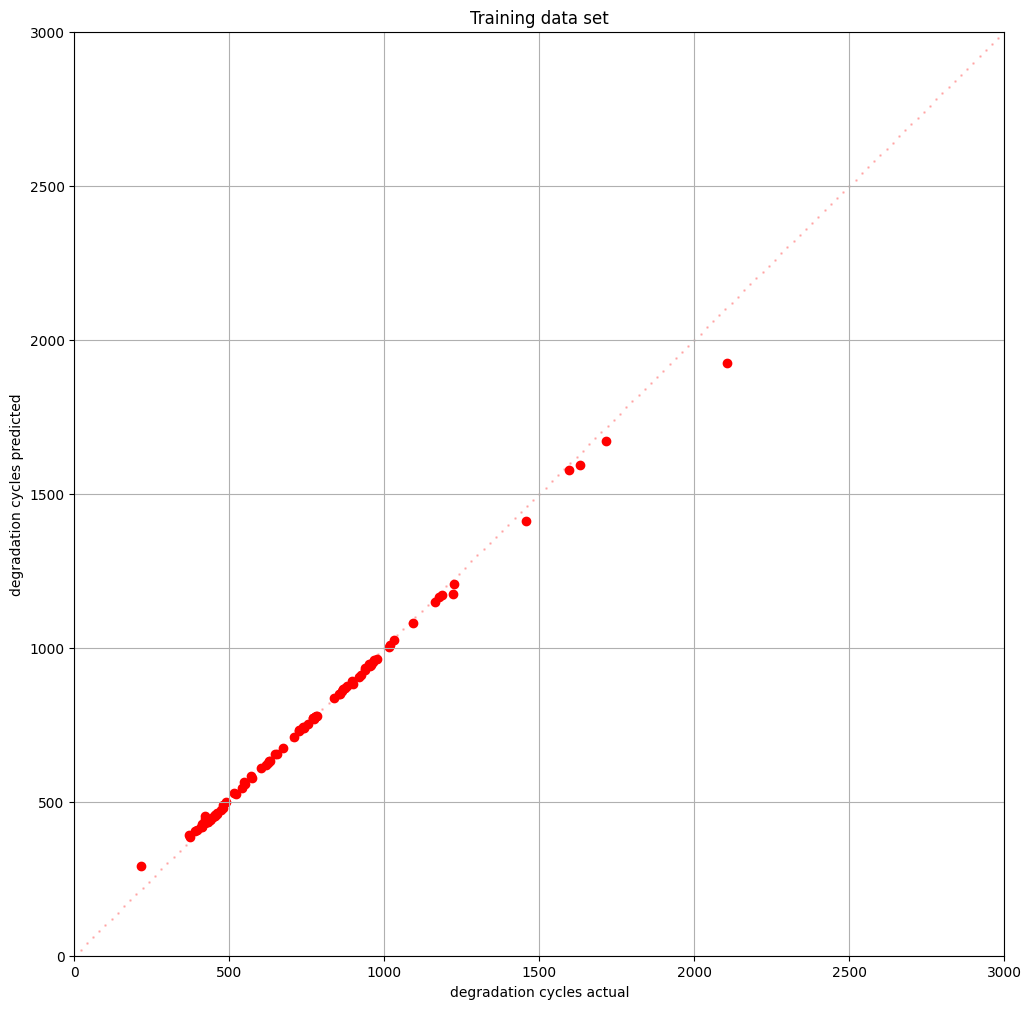

Max depth = 6
MdAPE is 12.236254935091006%
R2: 0.723, RMSE: 170.646, MAE: 132.352
Plotting scatter plot...


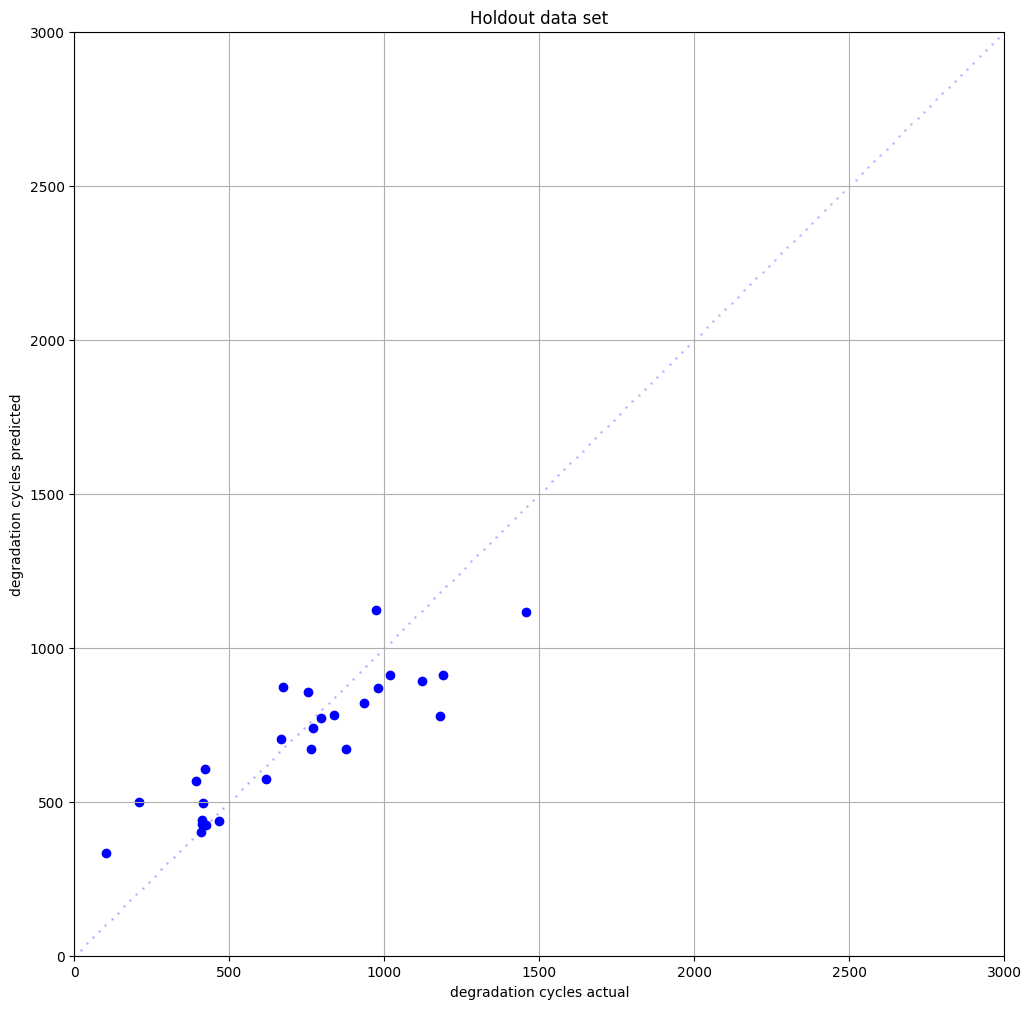

[02:01:56] ======== Monitor (0): HostSketchContainer ========
[02:01:56] AllReduce: 0.000167s, 1 calls @ 167us

[02:01:56] MakeCuts: 0.000619s, 1 calls @ 619us

[02:01:56] DEBUG: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:331.70673	validation_1-rmse:218.51908


/Users/willtong/Library/Caches/pypoetry/virtualenvs/wine-libraries-x_qLj7z9-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:01:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	validation_0-rmse:329.08190	validation_1-rmse:216.66002
[2000]	validation_0-rmse:326.48499	validation_1-rmse:214.83337
[3000]	validation_0-rmse:323.90526	validation_1-rmse:213.02070
[4000]	validation_0-rmse:321.35257	validation_1-rmse:211.24705
[5000]	validation_0-rmse:318.81548	validation_1-rmse:209.46612
[6000]	validation_0-rmse:316.30529	validation_1-rmse:207.72843
[7000]	validation_0-rmse:313.81272	validation_1-rmse:205.97261
[8000]	validation_0-rmse:311.34652	validation_1-rmse:204.26339
[9000]	validation_0-rmse:308.89891	validation_1-rmse:202.55654
[10000]	validation_0-rmse:306.47153	validation_1-rmse:200.87876
[11000]	validation_0-rmse:304.06852	validation_1-rmse:199.22277
[12000]	validation_0-rmse:301.68062	validation_1-rmse:197.57863
[13000]	validation_0-rmse:299.32079	validation_1-rmse:195.97153
[14000]	validation_0-rmse:296.97095	validation_1-rmse:194.35959
[15000]	validation_0-rmse:294.65066	validation_1-rmse:192.79080
[16000]	validation_0-rmse:292.34630	validation_1-

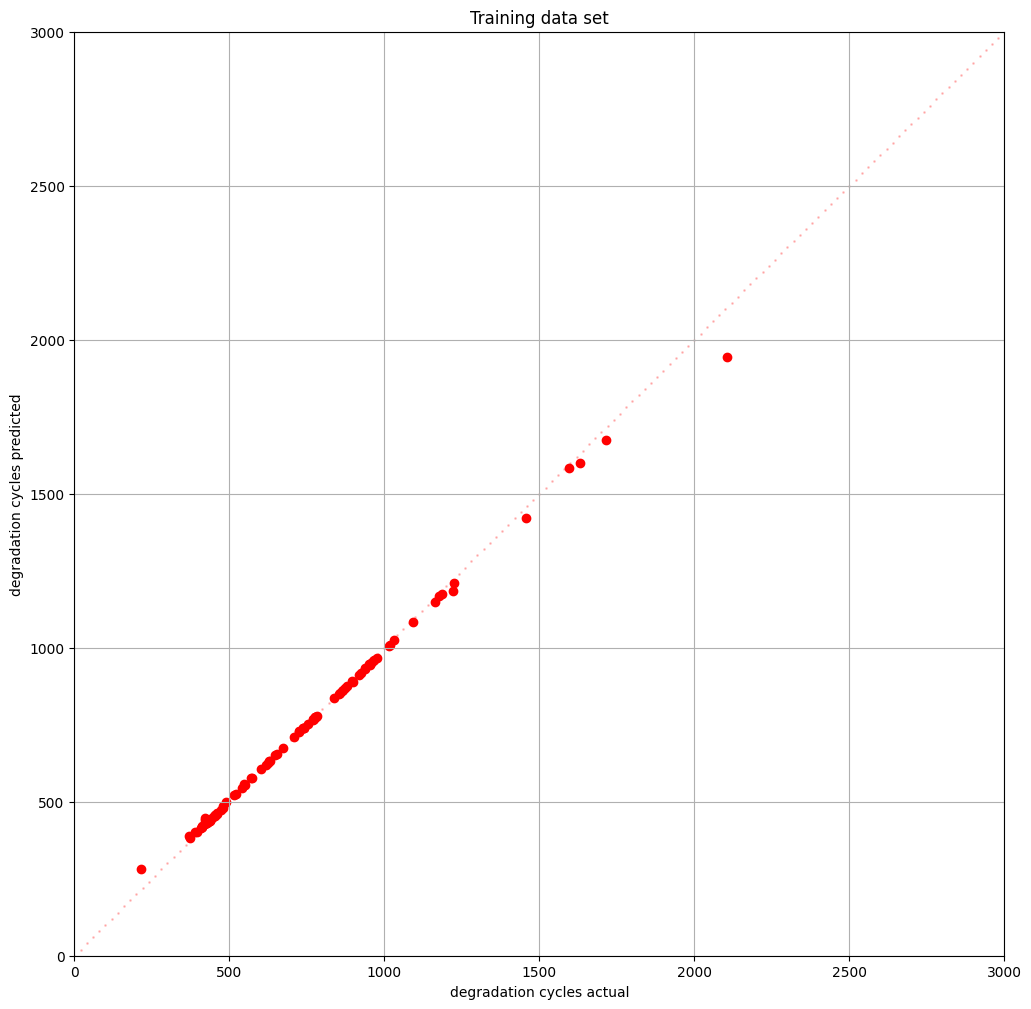

Max depth = 8
MdAPE is 12.592846627408994%
R2: 0.728, RMSE: 168.948, MAE: 131.614
Plotting scatter plot...


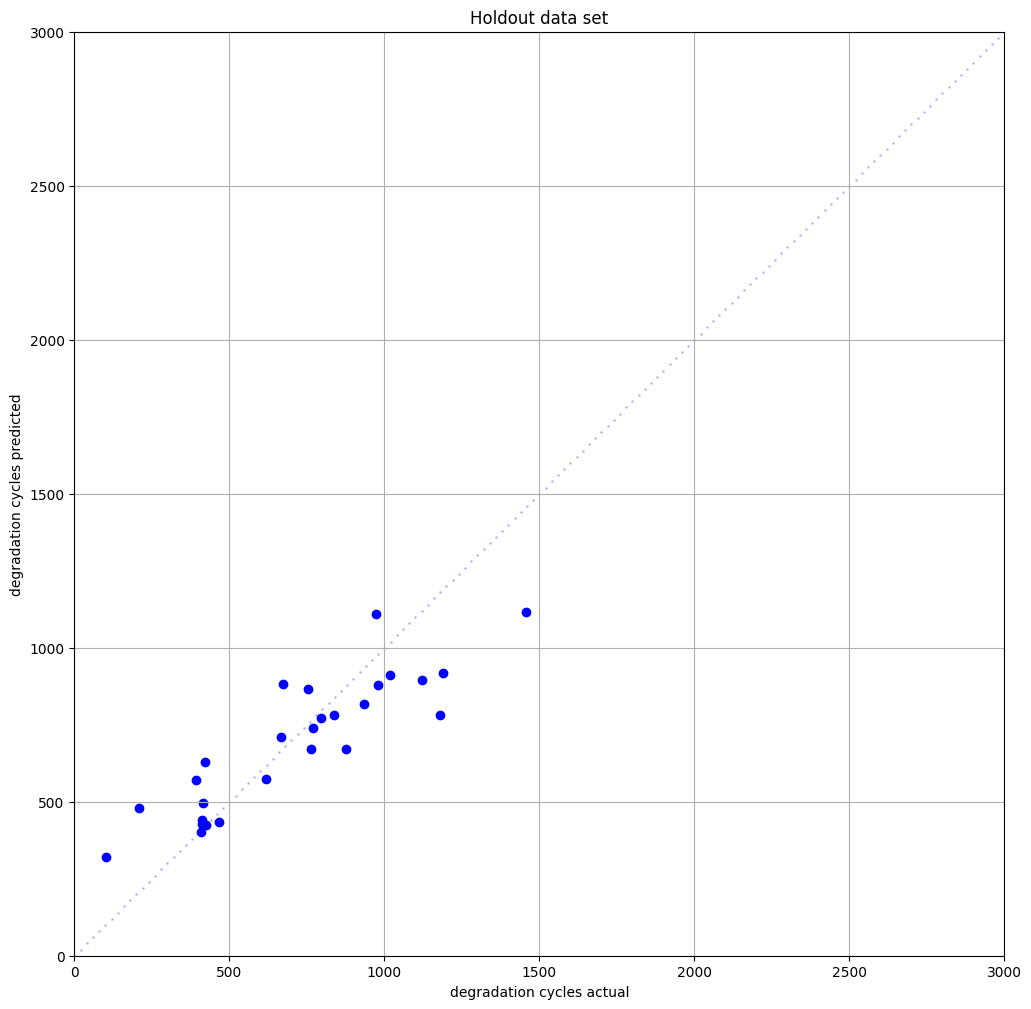

[02:34:55] ======== Monitor (0): HostSketchContainer ========
[02:34:55] AllReduce: 0.000179s, 1 calls @ 179us

[02:34:55] MakeCuts: 0.000574s, 1 calls @ 574us

[02:34:55] DEBUG: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:331.70673	validation_1-rmse:218.51908


/Users/willtong/Library/Caches/pypoetry/virtualenvs/wine-libraries-x_qLj7z9-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:34:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	validation_0-rmse:329.07906	validation_1-rmse:216.64266
[2000]	validation_0-rmse:326.48293	validation_1-rmse:214.80403
[3000]	validation_0-rmse:323.89943	validation_1-rmse:212.97662
[4000]	validation_0-rmse:321.34445	validation_1-rmse:211.19523
[5000]	validation_0-rmse:318.80595	validation_1-rmse:209.41186
[6000]	validation_0-rmse:316.29722	validation_1-rmse:207.65989
[7000]	validation_0-rmse:313.80489	validation_1-rmse:205.92365
[8000]	validation_0-rmse:311.33461	validation_1-rmse:204.22905
[9000]	validation_0-rmse:308.88702	validation_1-rmse:202.54288
[10000]	validation_0-rmse:306.46101	validation_1-rmse:200.87812
[11000]	validation_0-rmse:304.05649	validation_1-rmse:199.22311
[12000]	validation_0-rmse:301.66900	validation_1-rmse:197.57531
[13000]	validation_0-rmse:299.30988	validation_1-rmse:195.96163
[14000]	validation_0-rmse:296.96087	validation_1-rmse:194.33188
[15000]	validation_0-rmse:294.63762	validation_1-rmse:192.75380
[16000]	validation_0-rmse:292.33159	validation_1-

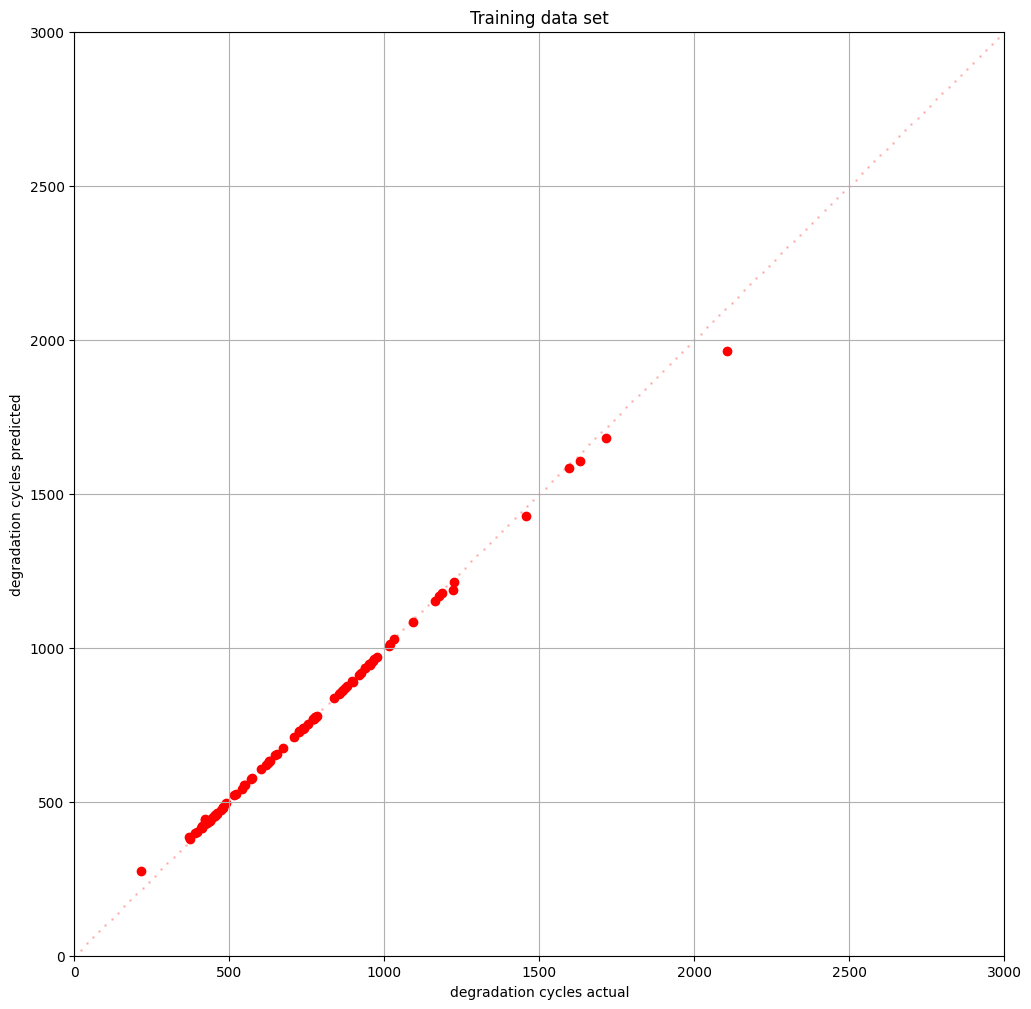

Max depth = 10
MdAPE is 12.61910350726044%
R2: 0.732, RMSE: 167.825, MAE: 130.694
Plotting scatter plot...


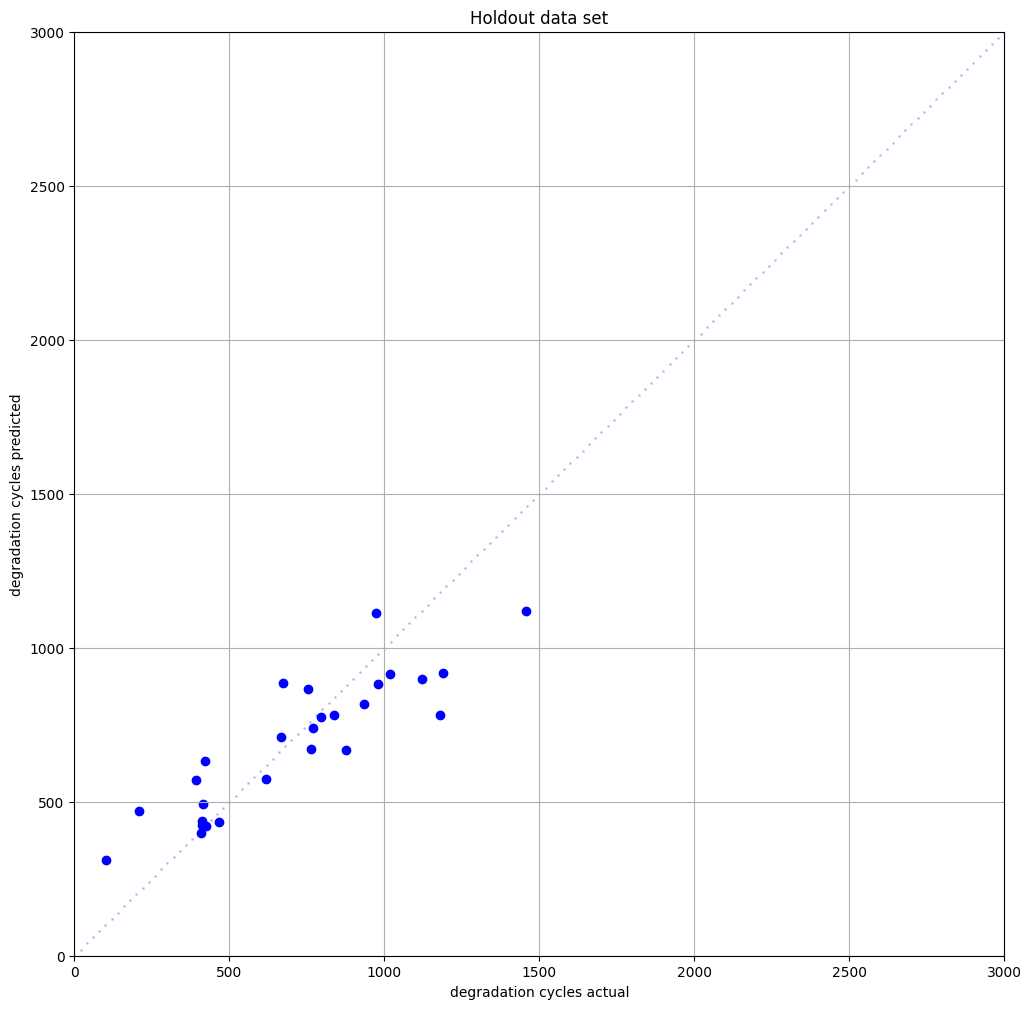

[03:13:06] ======== Monitor (0): HostSketchContainer ========
[03:13:06] AllReduce: 0.000174s, 1 calls @ 174us

[03:13:06] MakeCuts: 0.000282s, 1 calls @ 282us

[03:13:06] DEBUG: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:331.70673	validation_1-rmse:218.51908


/Users/willtong/Library/Caches/pypoetry/virtualenvs/wine-libraries-x_qLj7z9-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:13:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	validation_0-rmse:329.08068	validation_1-rmse:216.65250
[2000]	validation_0-rmse:326.48341	validation_1-rmse:214.83736
[3000]	validation_0-rmse:323.90148	validation_1-rmse:213.00118
[4000]	validation_0-rmse:321.34928	validation_1-rmse:211.22585
[5000]	validation_0-rmse:318.81093	validation_1-rmse:209.44867
[6000]	validation_0-rmse:316.30242	validation_1-rmse:207.71328
[7000]	validation_0-rmse:313.80906	validation_1-rmse:205.97009
[8000]	validation_0-rmse:311.34266	validation_1-rmse:204.26581
[9000]	validation_0-rmse:308.89353	validation_1-rmse:202.57772
[10000]	validation_0-rmse:306.46462	validation_1-rmse:200.89492
[11000]	validation_0-rmse:304.06107	validation_1-rmse:199.25042
[12000]	validation_0-rmse:301.67194	validation_1-rmse:197.60740
[13000]	validation_0-rmse:299.31286	validation_1-rmse:195.99451
[14000]	validation_0-rmse:296.96329	validation_1-rmse:194.36290
[15000]	validation_0-rmse:294.63898	validation_1-rmse:192.78886
[16000]	validation_0-rmse:292.33416	validation_1-

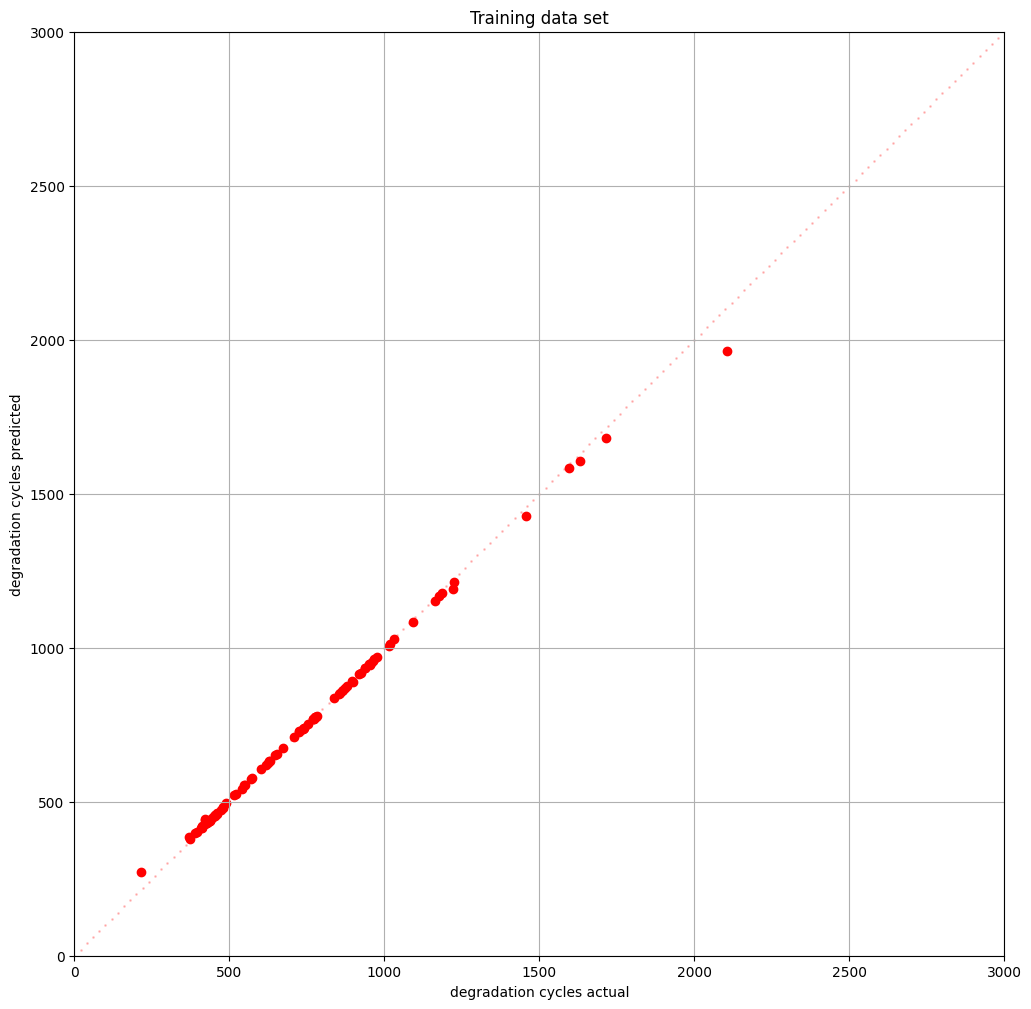

Max depth = 12
MdAPE is 12.740977775361348%
R2: 0.732, RMSE: 167.774, MAE: 130.757
Plotting scatter plot...


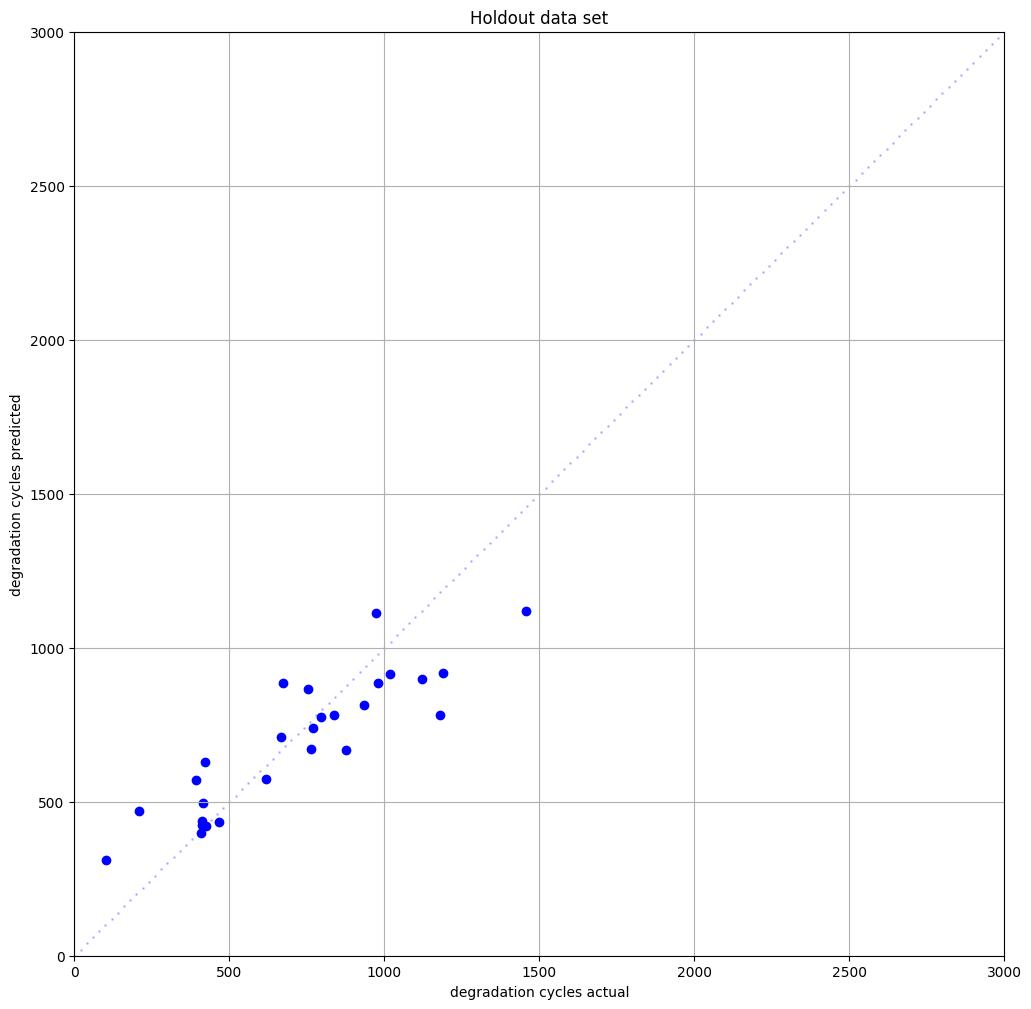

[03:52:19] ======== Monitor (0): HostSketchContainer ========
[03:52:19] AllReduce: 0.000168s, 1 calls @ 168us

[03:52:19] MakeCuts: 0.000266s, 1 calls @ 266us

[03:52:19] DEBUG: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:331.70673	validation_1-rmse:218.51908


/Users/willtong/Library/Caches/pypoetry/virtualenvs/wine-libraries-x_qLj7z9-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:52:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	validation_0-rmse:329.07968	validation_1-rmse:216.66827
[2000]	validation_0-rmse:326.48060	validation_1-rmse:214.83838
[3000]	validation_0-rmse:323.89739	validation_1-rmse:213.02443
[4000]	validation_0-rmse:321.34516	validation_1-rmse:211.25321
[5000]	validation_0-rmse:318.80601	validation_1-rmse:209.48029
[6000]	validation_0-rmse:316.29873	validation_1-rmse:207.73646
[7000]	validation_0-rmse:313.80326	validation_1-rmse:206.00767
[8000]	validation_0-rmse:311.33732	validation_1-rmse:204.29081
[9000]	validation_0-rmse:308.88878	validation_1-rmse:202.60593
[10000]	validation_0-rmse:306.46077	validation_1-rmse:200.93062
[11000]	validation_0-rmse:304.05363	validation_1-rmse:199.28019
[12000]	validation_0-rmse:301.66458	validation_1-rmse:197.62772
[13000]	validation_0-rmse:299.30055	validation_1-rmse:196.01930
[14000]	validation_0-rmse:296.95148	validation_1-rmse:194.39001
[15000]	validation_0-rmse:294.63039	validation_1-rmse:192.80700
[16000]	validation_0-rmse:292.32422	validation_1-

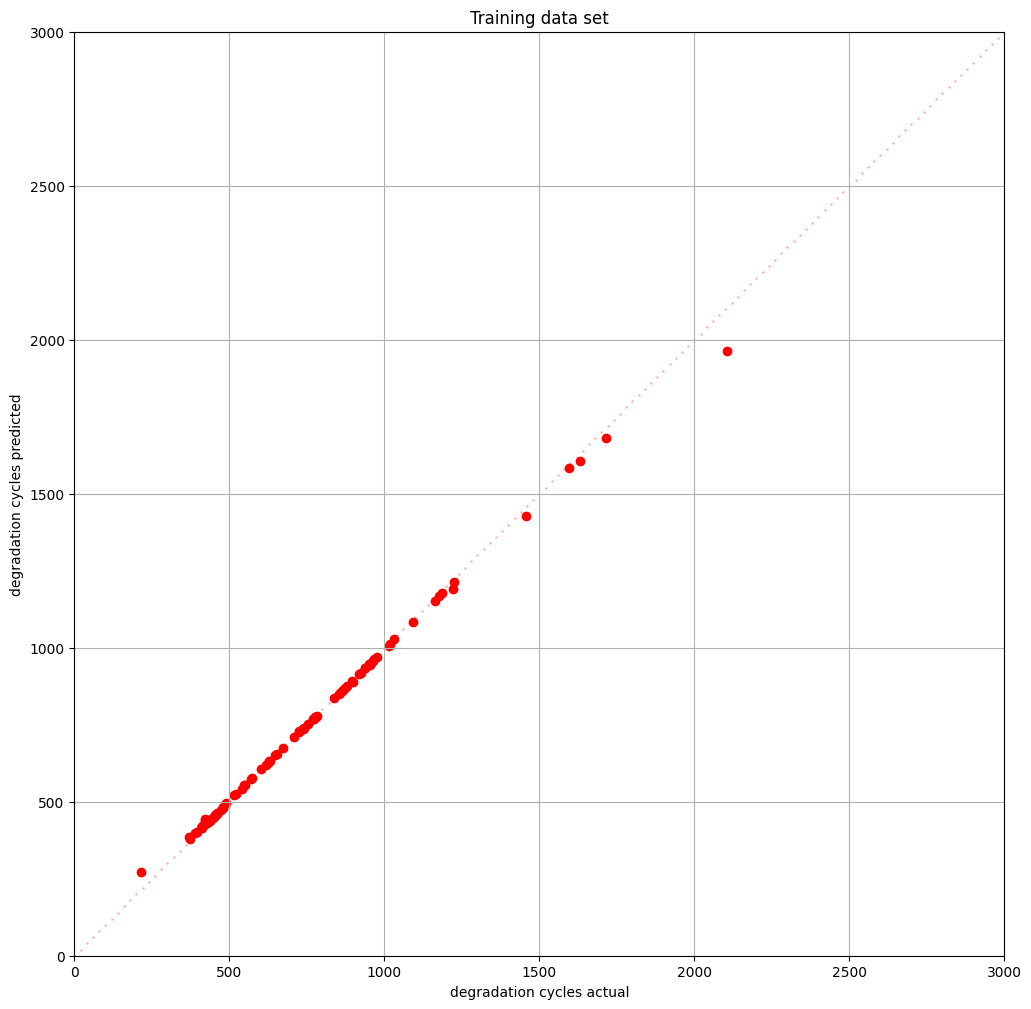

Max depth = 14
MdAPE is 12.683876576719754%
R2: 0.733, RMSE: 167.536, MAE: 130.577
Plotting scatter plot...


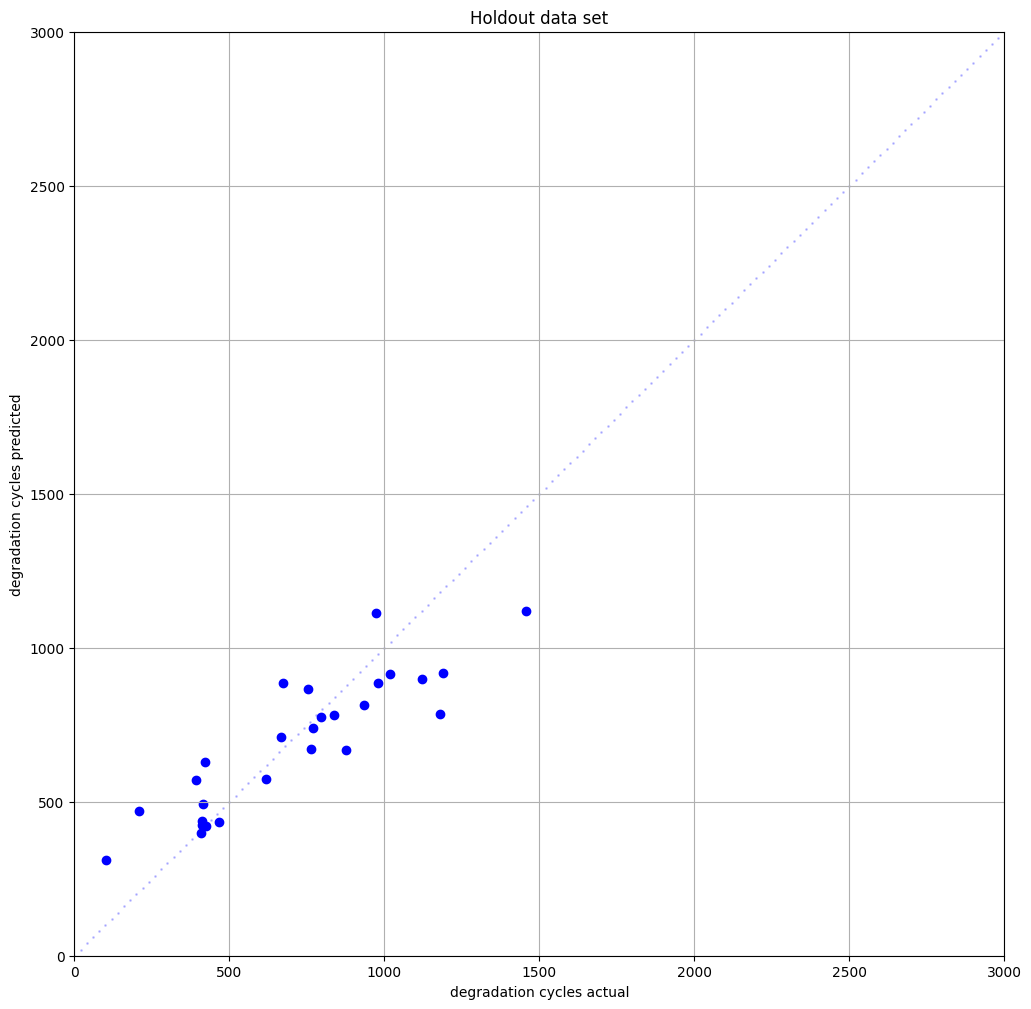

[04:31:40] ======== Monitor (0): HostSketchContainer ========
[04:31:40] AllReduce: 0.000169s, 1 calls @ 169us

[04:31:40] MakeCuts: 0.000275s, 1 calls @ 275us

[04:31:40] DEBUG: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:331.70673	validation_1-rmse:218.51908


/Users/willtong/Library/Caches/pypoetry/virtualenvs/wine-libraries-x_qLj7z9-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [04:31:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	validation_0-rmse:329.07968	validation_1-rmse:216.66827
[2000]	validation_0-rmse:326.48060	validation_1-rmse:214.83838
[3000]	validation_0-rmse:323.89739	validation_1-rmse:213.02443
[4000]	validation_0-rmse:321.34519	validation_1-rmse:211.25272
[5000]	validation_0-rmse:318.80601	validation_1-rmse:209.48739
[6000]	validation_0-rmse:316.29736	validation_1-rmse:207.74081
[7000]	validation_0-rmse:313.80350	validation_1-rmse:206.01059
[8000]	validation_0-rmse:311.33732	validation_1-rmse:204.29482
[9000]	validation_0-rmse:308.88954	validation_1-rmse:202.60470
[10000]	validation_0-rmse:306.46149	validation_1-rmse:200.93187
[11000]	validation_0-rmse:304.05429	validation_1-rmse:199.28152
[12000]	validation_0-rmse:301.66518	validation_1-rmse:197.62904
[13000]	validation_0-rmse:299.30125	validation_1-rmse:196.01924
[14000]	validation_0-rmse:296.95189	validation_1-rmse:194.39117
[15000]	validation_0-rmse:294.63120	validation_1-rmse:192.81340
[16000]	validation_0-rmse:292.32481	validation_1-

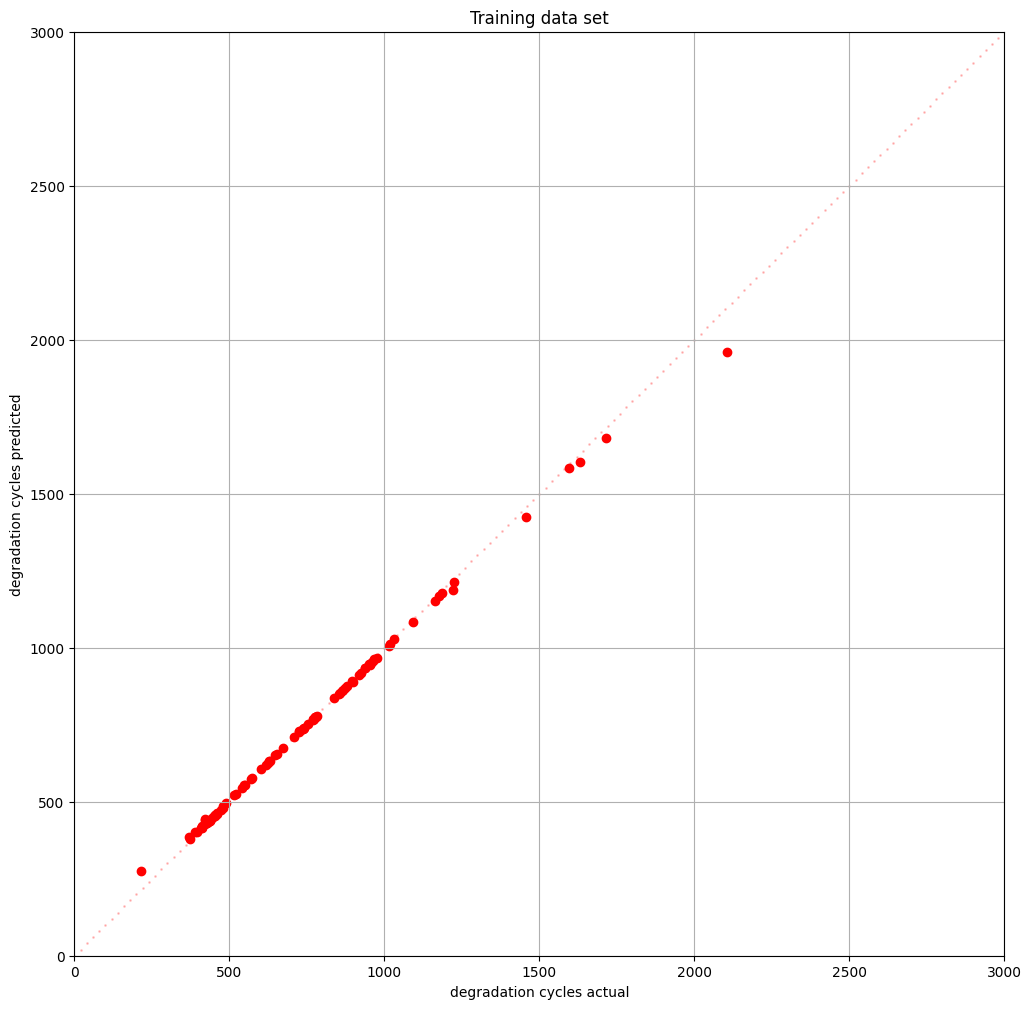

Max depth = 16
MdAPE is 12.724549254717612%
R2: 0.731, RMSE: 168.051, MAE: 131.006
Plotting scatter plot...


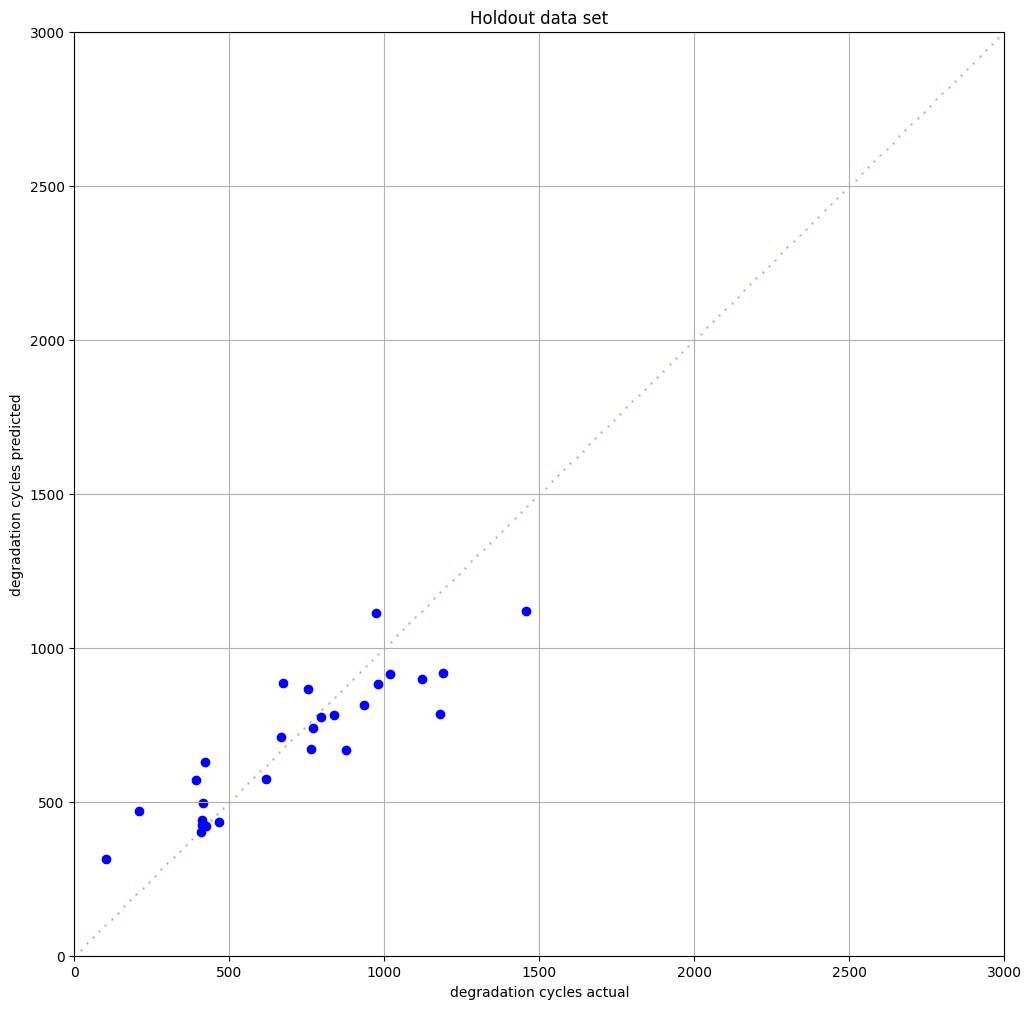

[05:10:22] ======== Monitor (0): HostSketchContainer ========
[05:10:22] AllReduce: 0.000169s, 1 calls @ 169us

[05:10:22] MakeCuts: 0.000315s, 1 calls @ 315us

[05:10:22] DEBUG: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:331.70673	validation_1-rmse:218.51908


/Users/willtong/Library/Caches/pypoetry/virtualenvs/wine-libraries-x_qLj7z9-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [05:10:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	validation_0-rmse:329.07968	validation_1-rmse:216.66827
[2000]	validation_0-rmse:326.48060	validation_1-rmse:214.83838
[3000]	validation_0-rmse:323.89739	validation_1-rmse:213.02443
[4000]	validation_0-rmse:321.34519	validation_1-rmse:211.25272
[5000]	validation_0-rmse:318.80601	validation_1-rmse:209.48739
[6000]	validation_0-rmse:316.29736	validation_1-rmse:207.74081
[7000]	validation_0-rmse:313.80350	validation_1-rmse:206.01059
[8000]	validation_0-rmse:311.33732	validation_1-rmse:204.29482
[9000]	validation_0-rmse:308.88954	validation_1-rmse:202.60470
[10000]	validation_0-rmse:306.46149	validation_1-rmse:200.93187
[11000]	validation_0-rmse:304.05429	validation_1-rmse:199.28152
[12000]	validation_0-rmse:301.66518	validation_1-rmse:197.62904
[13000]	validation_0-rmse:299.30125	validation_1-rmse:196.01924
[14000]	validation_0-rmse:296.95189	validation_1-rmse:194.39117
[15000]	validation_0-rmse:294.63120	validation_1-rmse:192.81340
[16000]	validation_0-rmse:292.32481	validation_1-

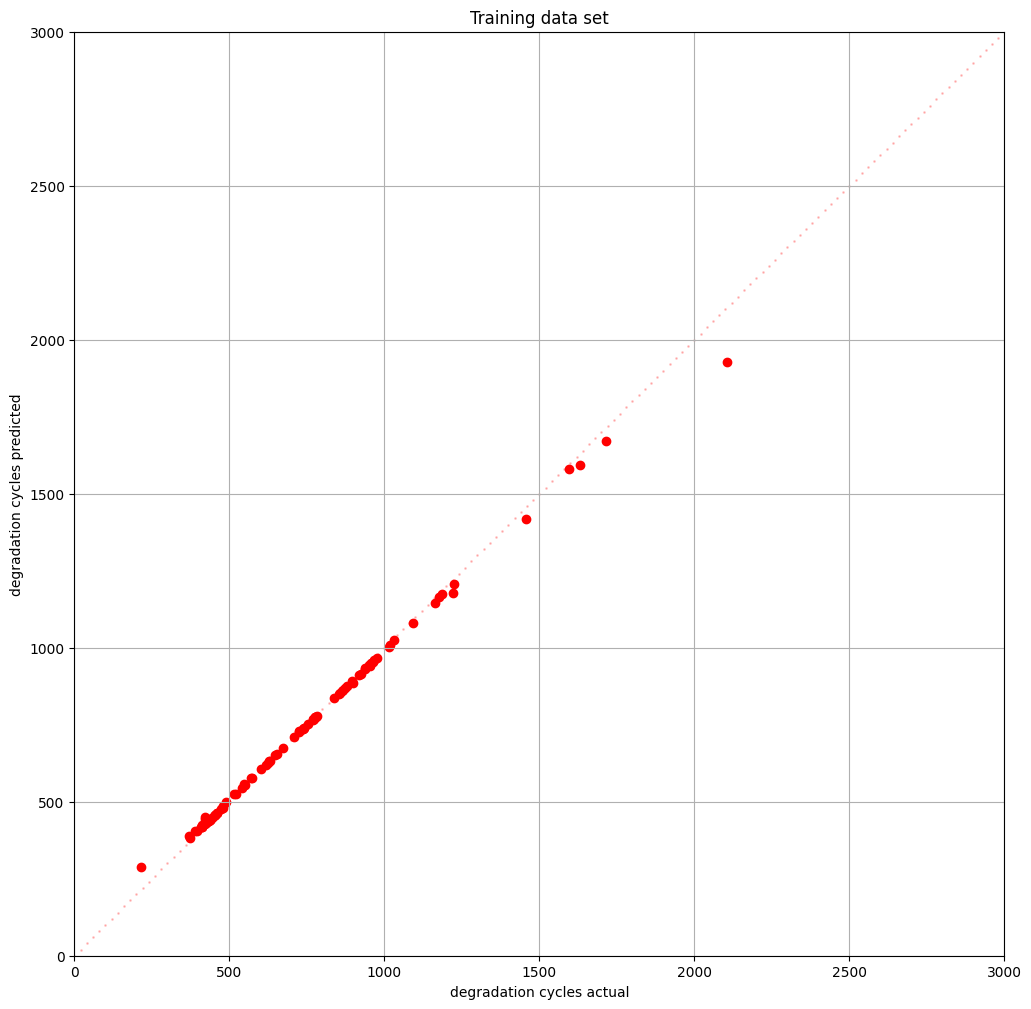

Max depth = 18
MdAPE is 12.819114538025294%
R2: 0.725, RMSE: 170.032, MAE: 132.211
Plotting scatter plot...


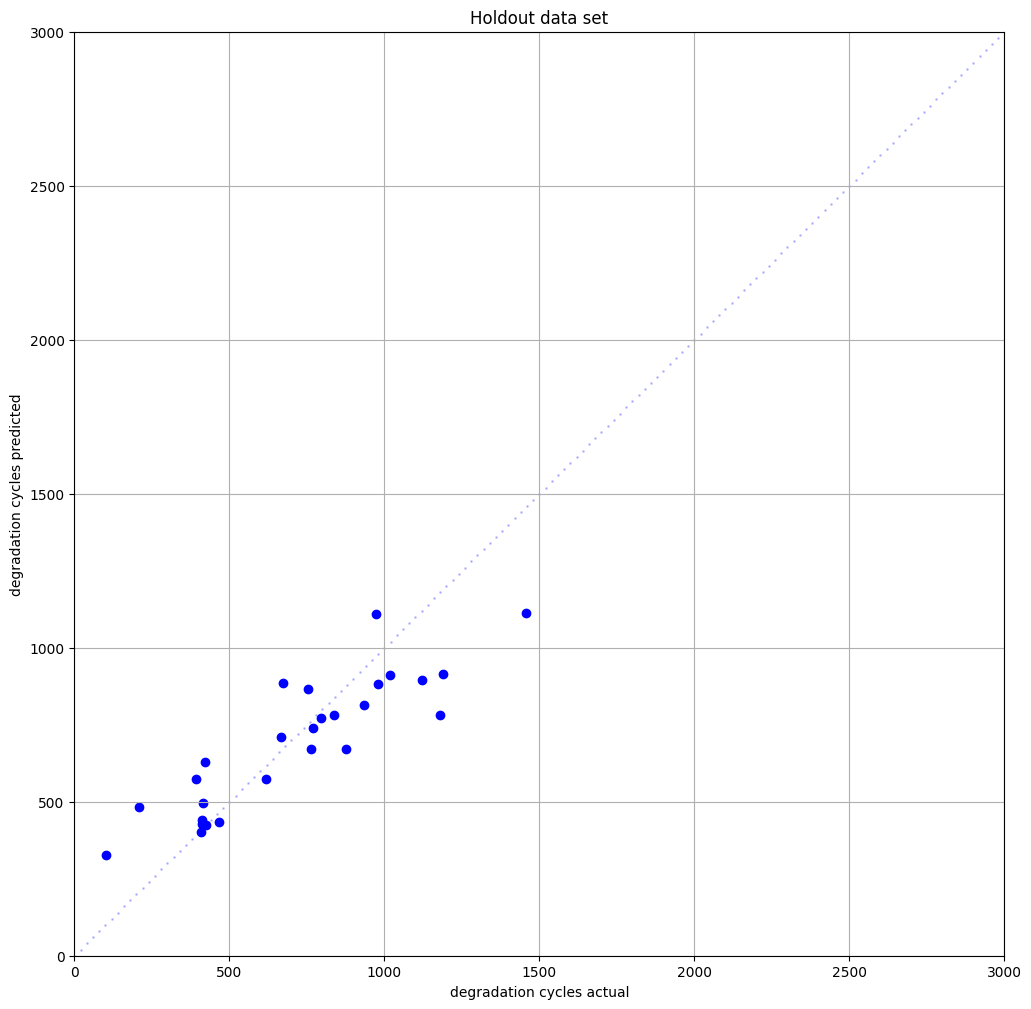

[05:45:28] ======== Monitor (0): HostSketchContainer ========
[05:45:28] AllReduce: 0.000176s, 1 calls @ 176us

[05:45:28] MakeCuts: 0.000318s, 1 calls @ 318us

[05:45:28] DEBUG: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:331.70673	validation_1-rmse:218.51908


/Users/willtong/Library/Caches/pypoetry/virtualenvs/wine-libraries-x_qLj7z9-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [05:45:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	validation_0-rmse:329.07968	validation_1-rmse:216.66827
[2000]	validation_0-rmse:326.48060	validation_1-rmse:214.83838
[3000]	validation_0-rmse:323.89739	validation_1-rmse:213.02443
[4000]	validation_0-rmse:321.34519	validation_1-rmse:211.25272
[5000]	validation_0-rmse:318.80601	validation_1-rmse:209.48739
[6000]	validation_0-rmse:316.29736	validation_1-rmse:207.74081
[7000]	validation_0-rmse:313.80350	validation_1-rmse:206.01059
[8000]	validation_0-rmse:311.33732	validation_1-rmse:204.29482
[9000]	validation_0-rmse:308.88954	validation_1-rmse:202.60470
[10000]	validation_0-rmse:306.46149	validation_1-rmse:200.93187
[11000]	validation_0-rmse:304.05429	validation_1-rmse:199.28152
[12000]	validation_0-rmse:301.66518	validation_1-rmse:197.62904
[13000]	validation_0-rmse:299.30125	validation_1-rmse:196.01924
[14000]	validation_0-rmse:296.95189	validation_1-rmse:194.39117
[15000]	validation_0-rmse:294.63120	validation_1-rmse:192.81340
[16000]	validation_0-rmse:292.32481	validation_1-

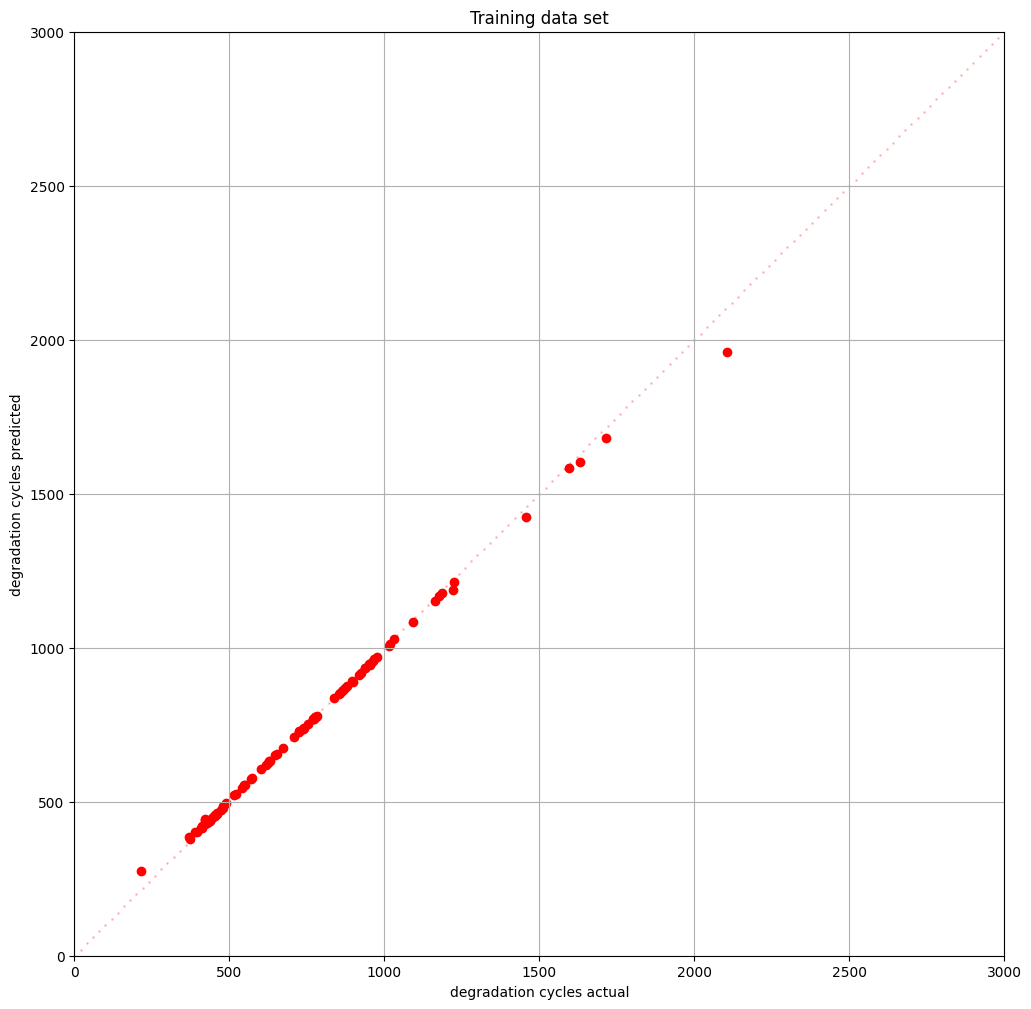

Max depth = 20
MdAPE is 12.738899704730997%
R2: 0.731, RMSE: 168.003, MAE: 130.953
Plotting scatter plot...


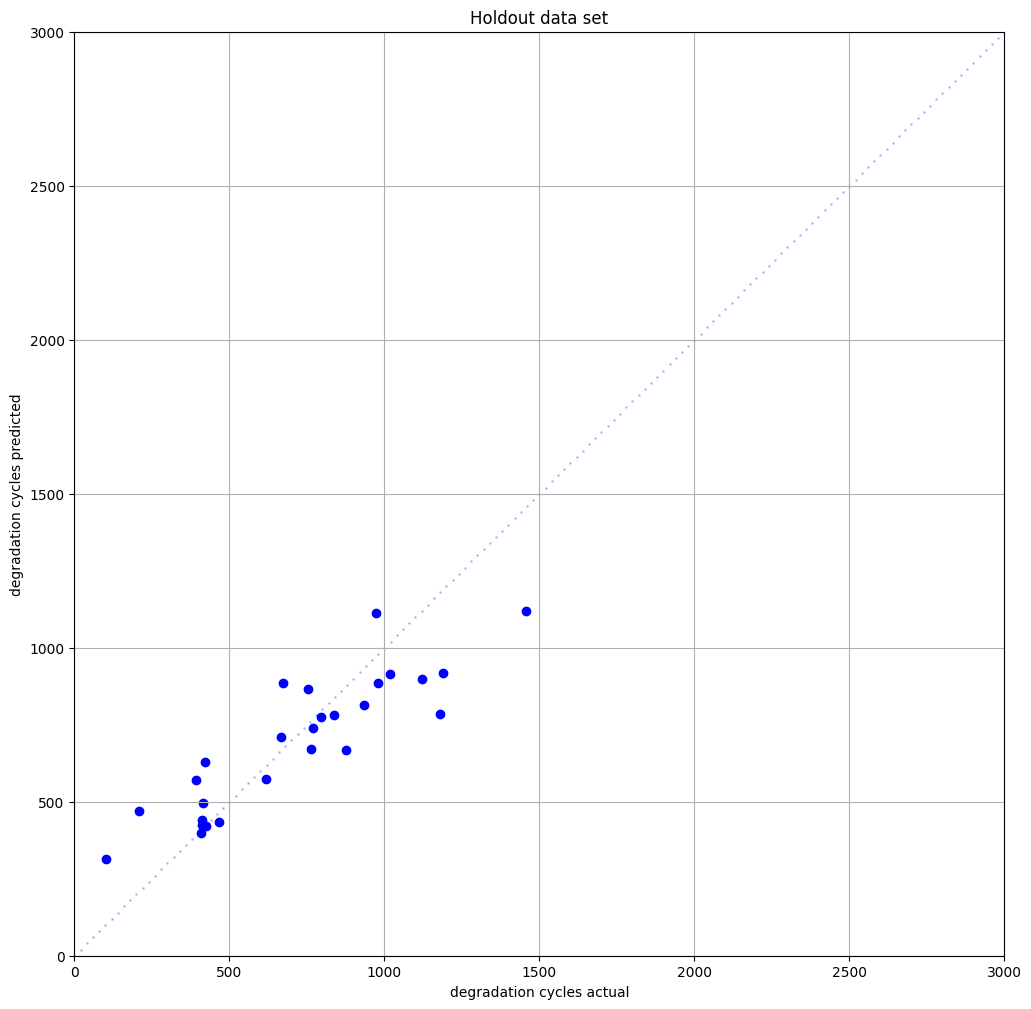

In [13]:
for max_depth in range(2,21,2):
    xgboost_params["max_depth"]= max_depth 
    gbm = Tree_Model(Model = XGBRegressor,
                     params = xgboost_params,
                     cycle_max = 3000
                     )
    gbm.fit(X_train, y_train)
    print(f'Max depth = {max_depth}')
    gbm.predict(X_test, y_test)
    

MdAPE is 12.236254935091006%
R2: 0.723, RMSE: 170.646, MAE: 132.352
Plotting scatter plot...


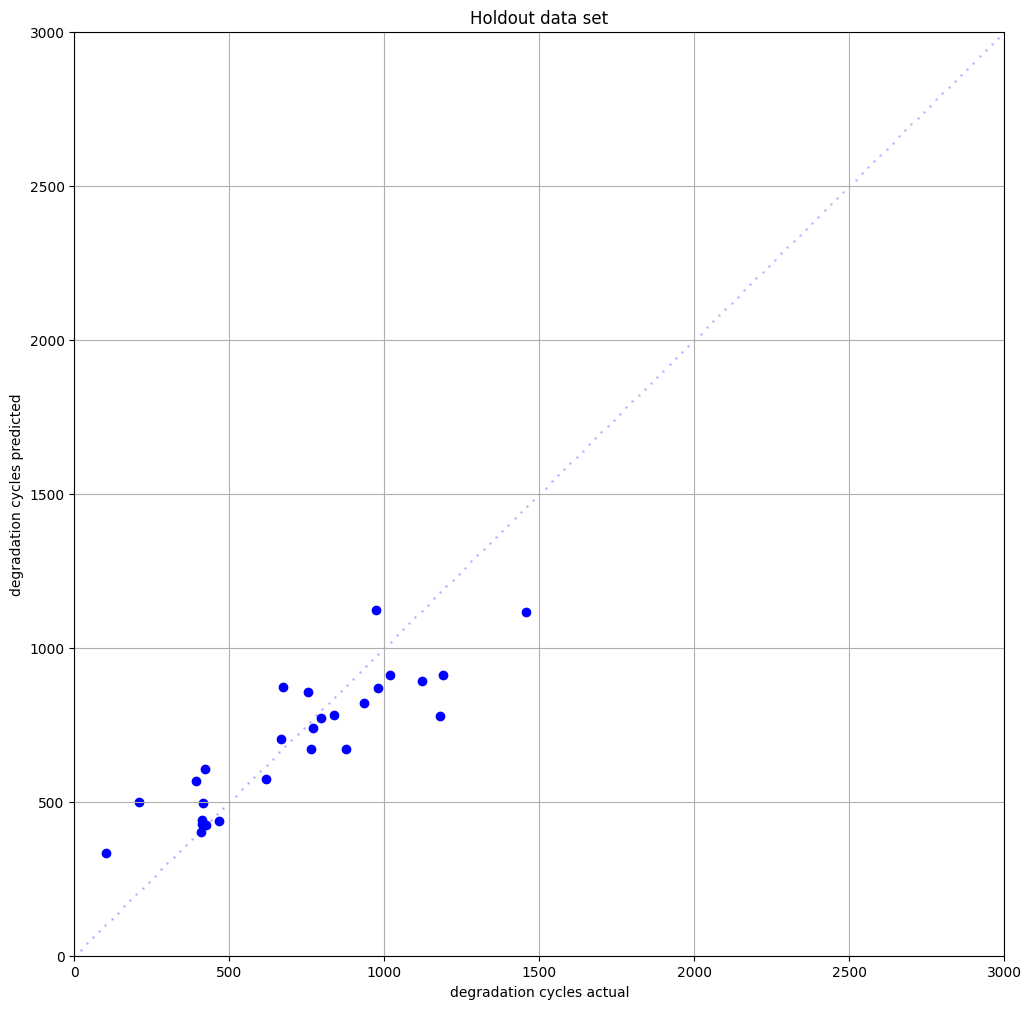

array([ 442.00012,  497.7571 , 1123.5223 ,  777.0828 ,  770.65436,
        425.06833,  857.2555 ,  871.9458 ,  333.55838,  567.664  ,
        739.6834 ,  426.83133,  890.4534 ,  573.5506 ,  436.31656,
       1117.5294 ,  868.7627 ,  669.5976 ,  401.42743,  672.5231 ,
        495.28687,  910.6956 ,  607.60004,  912.0287 ,  781.82886,
        819.7134 ,  704.99255], dtype=float32)

In [24]:
gbm.predict(X_test, y_test)

## Best results: Max depth = 6 

[14:37:09] ======== Monitor (0): HostSketchContainer ========
[14:37:09] AllReduce: 0.000484s, 1 calls @ 484us

[14:37:09] MakeCuts: 0.00132s, 1 calls @ 1320us

[14:37:09] DEBUG: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:331.70675	validation_1-rmse:218.51909


/Users/willtong/Library/Caches/pypoetry/virtualenvs/wine-libraries-x_qLj7z9-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:37:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	validation_0-rmse:329.09452	validation_1-rmse:216.66278
[2000]	validation_0-rmse:326.51486	validation_1-rmse:214.86065
[3000]	validation_0-rmse:323.94852	validation_1-rmse:213.05348
[4000]	validation_0-rmse:321.40796	validation_1-rmse:211.27382
[5000]	validation_0-rmse:318.88535	validation_1-rmse:209.51787
[6000]	validation_0-rmse:316.39140	validation_1-rmse:207.78720
[7000]	validation_0-rmse:313.91152	validation_1-rmse:206.04888
[8000]	validation_0-rmse:311.45591	validation_1-rmse:204.33838
[9000]	validation_0-rmse:309.02591	validation_1-rmse:202.65674
[10000]	validation_0-rmse:306.61355	validation_1-rmse:200.99522
[11000]	validation_0-rmse:304.22056	validation_1-rmse:199.34860
[12000]	validation_0-rmse:301.84708	validation_1-rmse:197.71271
[13000]	validation_0-rmse:299.49911	validation_1-rmse:196.10603
[14000]	validation_0-rmse:297.16349	validation_1-rmse:194.49211
[15000]	validation_0-rmse:294.85781	validation_1-rmse:192.91768
[16000]	validation_0-rmse:292.56622	validation_1-

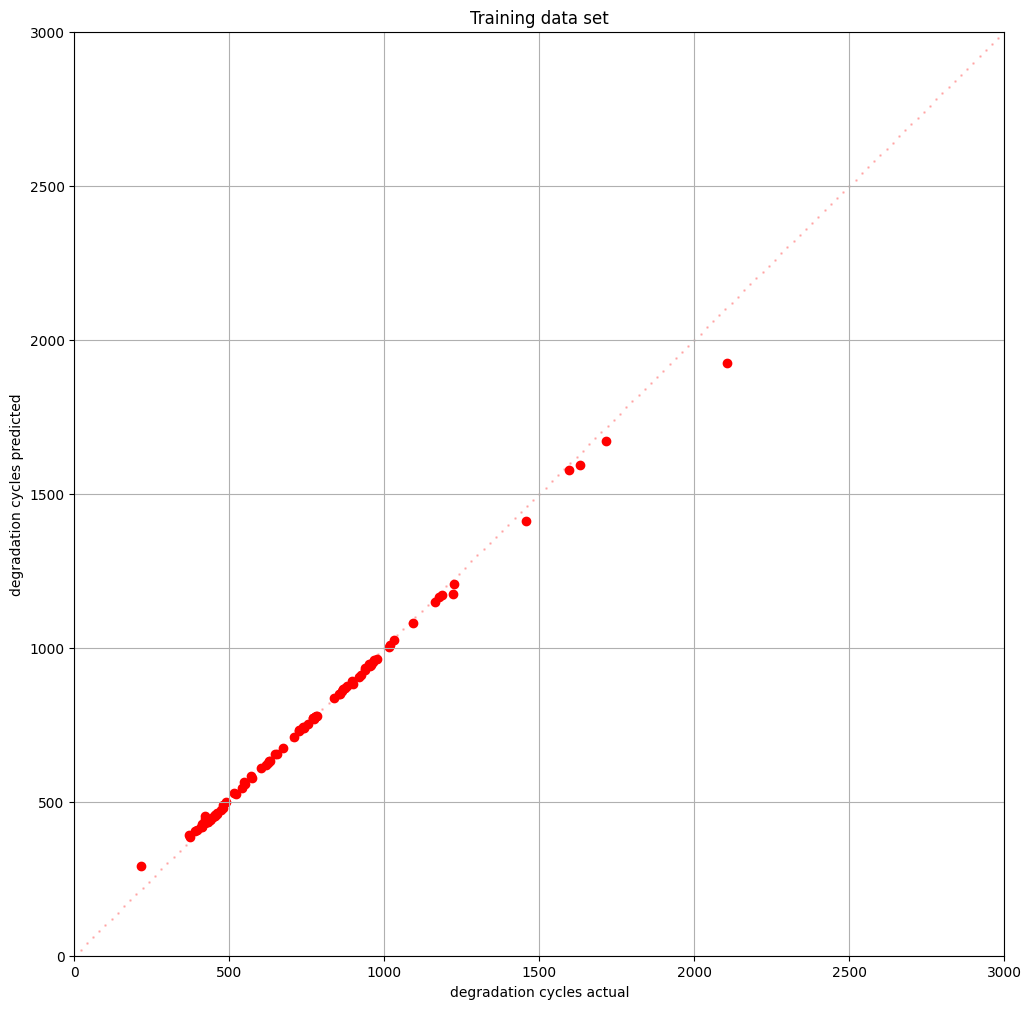

Max depth = 6
MdAPE is 12.236254935091006%
R2: 0.723, RMSE: 170.646, MAE: 132.352
Plotting scatter plot...


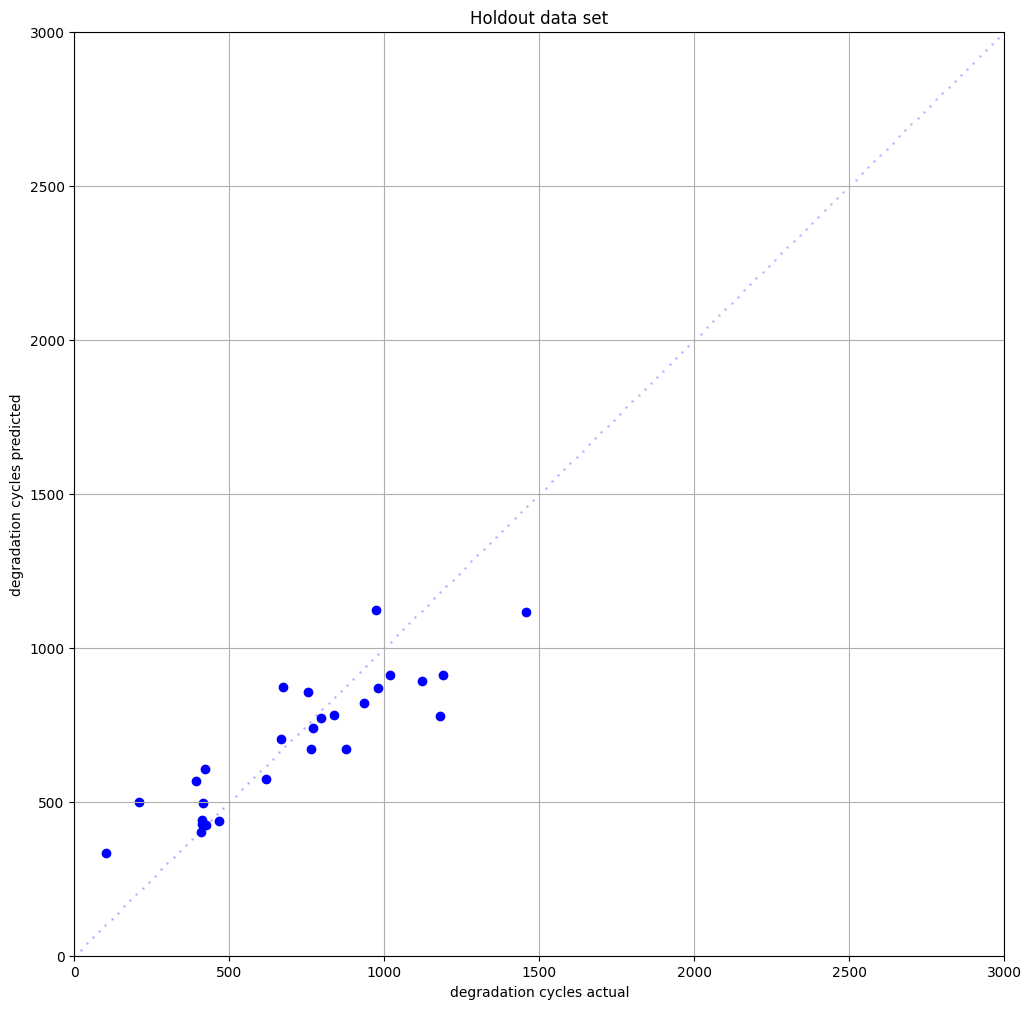

array([ 442.00012,  497.7571 , 1123.5223 ,  777.0828 ,  770.65436,
        425.06833,  857.2555 ,  871.9458 ,  333.55838,  567.664  ,
        739.6834 ,  426.83133,  890.4534 ,  573.5506 ,  436.31656,
       1117.5294 ,  868.7627 ,  669.5976 ,  401.42743,  672.5231 ,
        495.28687,  910.6956 ,  607.60004,  912.0287 ,  781.82886,
        819.7134 ,  704.99255], dtype=float32)

In [26]:
max_depth = 6
xgboost_params["max_depth"]= max_depth
gbm = Tree_Model(Model = XGBRegressor,
                 params = xgboost_params,
                 cycle_max = 3000
                 )
gbm.fit(X_train, y_train)
print(f'Max depth = {max_depth}')
gbm.predict(X_test, y_test)


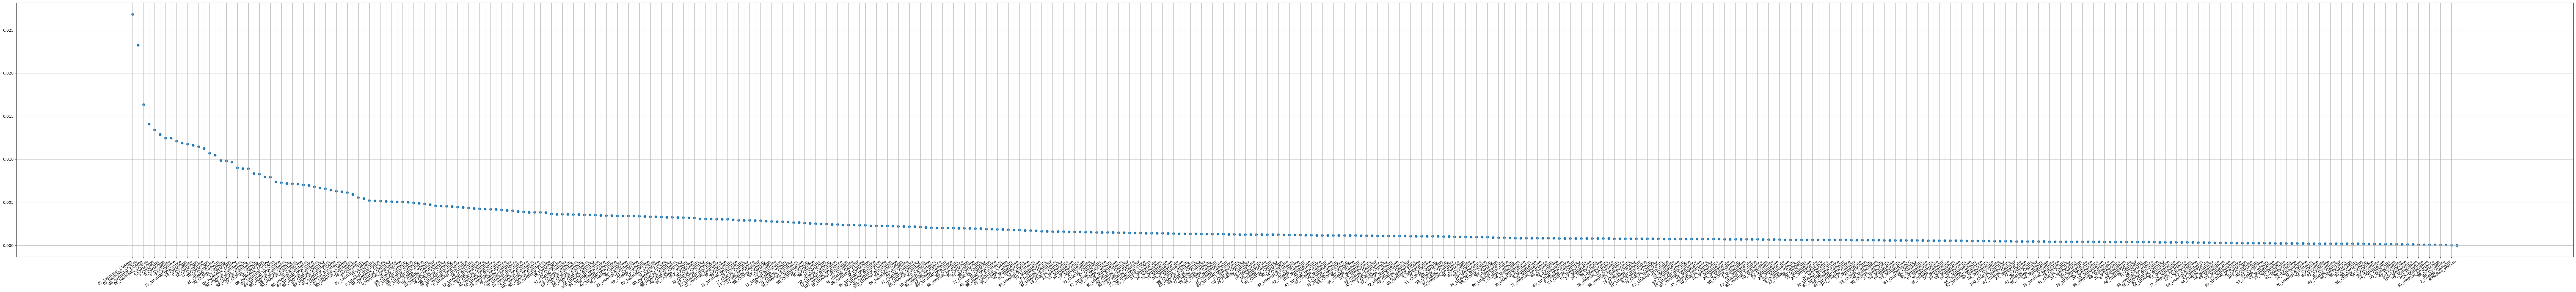

In [27]:
data_points =[x[0] for x in gbm.feature_imp]
importances =[x[1] for x in gbm.feature_imp]
plt.figure(figsize=(120,12))
plt.scatter(data_points, importances)
plt.xticks(rotation = 35, horizontalalignment = 'right')
plt.grid()
plt.savefig('images/feature_imp.png')
plt.show()


In [28]:
 [(x[0], float(x[1])) for x in gbm.feature_imp]

[('07_harmonic_CVArea', 0.02682437002658844),
 ('07_harmonic_CCArea', 0.02325589768588543),
 ('08_harmonic_CCArea', 0.016336964443325996),
 ('06_harmonic_CCArea', 0.014096577651798725),
 ('4_CycleTime', 0.013408180326223373),
 ('5_CycleTime', 0.012869476340711117),
 ('8_CycleTime', 0.012460002675652504),
 ('6_CycleTime', 0.01245040912181139),
 ('7_CycleTime', 0.01210287120193243),
 ('25_Internal_Resistance', 0.01188181433826685),
 ('13_CycleTime', 0.01173782255500555),
 ('9_CycleTime', 0.011622701771557331),
 ('12_CycleTime', 0.011473051272332668),
 ('11_CycleTime', 0.011254369281232357),
 ('10_CycleTime', 0.010701070539653301),
 ('15_CycleTime', 0.010467289946973324),
 ('26_Charge_Capacity', 0.00986053328961134),
 ('30_Charge_Capacity', 0.009793008677661419),
 ('14_CycleTime', 0.009667717851698399),
 ('04_harmonic_CCArea', 0.008999248966574669),
 ('91_Internal_Resistance', 0.008908811956644058),
 ('79_Charge_Capacity', 0.008903677575290203),
 ('92_Internal_Resistance', 0.0083481390029

In [29]:
importances_sums = {}
for feature_imp in gbm.feature_imp:
    category = feature_imp[0].split('_')[-1]
    if category in importances_sums.keys():
        importances_sums[category] += float(feature_imp[1])
    else:
        importances_sums[category] = float(feature_imp[1])
import_sums = [(key, importances_sums[key]) for key in importances_sums.keys()]

import_sums = sorted(import_sums, key=lambda x: x[1], reverse = True)
str([(x[0], float(np.round(x[1], 5))) for x in import_sums])

"[('CycleTime', 0.28186), ('Resistance', 0.27551), ('Capacity', 0.21631), ('CCArea', 0.09005), ('Temperature', 0.07628), ('CVArea', 0.05878), ('maxfreqCV', 0.00063), ('maxfreqCC', 0.00057), ('version', 0.0)]"